# Import

In [26]:
import numpy as np
import matplotlib.pyplot as plt

from hnc_Ng import  HNC_solver
from qsps import *

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
        
        
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

Ha_to_J = 4.359744e-18
k_B = 1.380649e-23 
m_p = 1.672621898e-27 # kg
eV_to_K = 11604.5250061598
J_to_erg = 1e7
Ha_to_erg = Ha_to_J*J_to_erg

# Function that sets up HNC QSP 

In [2]:
def set_hnc(n_in_per_cc, T, Z, A, Zstar, c_k_guess=None , which_Tij='thermal',
            oz_type='standard', method='kryov', add_bridge=False, bridge='yukawa',
            pseudopotential=False, r_c=0.6, no_coupling=False, N_bins = 500, R_max=5):
    
    n_in_AU = n_in_per_cc*1e6 *aB**3
    ri = QSP_HNC.rs_from_n(n_in_AU)
    qsp = QSP_HNC(Z, A, Zstar, T, T, ri, Zstar*n_in_AU, which_Tij=which_Tij, r_c=r_c)

    N_species = 2
    Gamma = np.array(  [[qsp.Γii,  qsp.Γei],
                        [qsp.Γei,  qsp.Γee]])


    names = ["Ion-1", "Electron", ] 
    kappa = 1
    
    rhos = np.array([  3/(4*np.pi), Zstar*3/(4*np.pi) ])
    temps = np.array([qsp.Ti, qsp.Te_c])
    masses= np.array([qsp.m_i, m_e])
    hnc1 = HNC_solver(N_species, Gamma, rhos, temps, masses ,
                     kappa_multiscale=10, R_max=R_max, N_bins=N_bins, 
                      names=names, dst_type=3, oz_method=oz_type)

    if pseudopotential==True:
        βvei = qsp.βvei_atomic(hnc1.r_array)
    else:
        βvei = qsp.βvei(hnc1.r_array)
    βu_r_matrix = np.array([[qsp.βvii(hnc1.r_array), βvei],
                            [βvei, qsp.βvee(hnc1.r_array)]])
    if no_coupling:
        βu_r_matrix[0,1]=0
        βu_r_matrix[1,0]=0
    
    if add_bridge:
        if bridge=='ocp':
            βu_r_matrix[0,0] = βu_r_matrix[0,0] - hnc1.Bridge_function_OCP(hnc1.r_array, qsp.Γii)
        elif bridge=='yukawa':
            βu_r_matrix[0,0] = βu_r_matrix[0,0] - hnc1.Bridge_function_Yukawa(hnc1.r_array, qsp.Γii, qsp.get_κ())
    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
#     print("c asymm: ", hnc1.c_s_k_matrix[1,0]/hnc1.c_s_k_matrix[0,1])
    if c_k_guess is not None:
        for i in range(N_species):
            for j in range(N_species):
                if (c_k_guess[i,j]!=np.zeros(hnc1.N_bins)).all():
#                 if i==j:
                    hnc1.c_k_matrix[i,j] = c_k_guess[i,j]
                    hnc1.c_r_matrix[i,j] = hnc1.FT_k_2_r(hnc1.c_k_matrix[i,j])
                    hnc1.c_s_k_matrix[i,j] = hnc1.c_k_matrix[i,j] + hnc1.βu_l_k_matrix[i,j]
                    hnc1.c_s_r_matrix[i,j] = hnc1.c_r_matrix[i,j] + hnc1.βu_l_r_matrix[i,j]

#     print("c asymm: ", hnc1.c_s_k_matrix[1,0]/hnc1.c_s_k_matrix[0,1])
    hnc1.set_C_matrix()

    return hnc1, qsp

## Load TCCW Cases

In [3]:
AU_to_Pa  = 2.9421015697e13 
Pa_to_bar = 1e-5
AU_to_bar = AU_to_Pa*Pa_to_bar 

In [4]:
mixture_file = "/home/zach/plasma/hnc/data/TCCW_single_species_data.csv"
tccw_mixture_data = read_csv(mixture_file)
tccw_cases = [tccw_mixture_data.iloc[n] for n in range(len(tccw_mixture_data))]

case_successes = {}
SVT_case_successes = {}
# R_max = 3
# N_bins = 100
max_attempts=1

tccw_case = tccw_cases[0]
α = 0.1
case_converged=False
case_attempts=0
case_num= tccw_case[' ']
case_id = tccw_case['Case ID']
ni_cc = tccw_case['Number Density [N/cc]']
Te = tccw_case['Temperature [eV]']*eV
Ti = Te
Z = tccw_case['Atomic Number']
Zstar = tccw_case['Zbar (TFDW)']
P_GP_AU  = tccw_case['p (Bar)']/AU_to_bar
A = tccw_case['Atomic Weight [a.u.]']
r_s_cc = tccw_case['Wigner-Seitz Radius [cm]']
r_c = tccw_case['Average-Bound Radius [cm]']/r_s_cc
if r_c>1:
    r_c=1e-5
print('\n______________________________\nCase num: {0} Case ID: {1}'.format(case_num, case_id))
print("Te = {0:.3e} eV, n_i = {1:.3e} 1/cc, r_c/r_s = {2:.3f}".format(Te/eV, ni_cc, r_c))
print("Te = {0:.3e} K, ρ = {1:.3e} [g/cc] ".format(Te/eV*eV_to_K, 1e3*ni_cc*m_p*A ))
print("P  = {0:.3e} [bar] = {1:.3e} [AU]".format(P_GP_AU*AU_to_bar, P_GP_AU))


______________________________
Case num: 0 Case ID: H1
Te = 2.000e+00 eV, n_i = 5.980e+23 1/cc, r_c/r_s = 0.371
Te = 2.321e+04 K, ρ = 1.008e+00 [g/cc] 
P  = 2.810e+06 [bar] = 9.551e-03 [AU]


# Make atom

NameError: name 'atom_table' is not defined

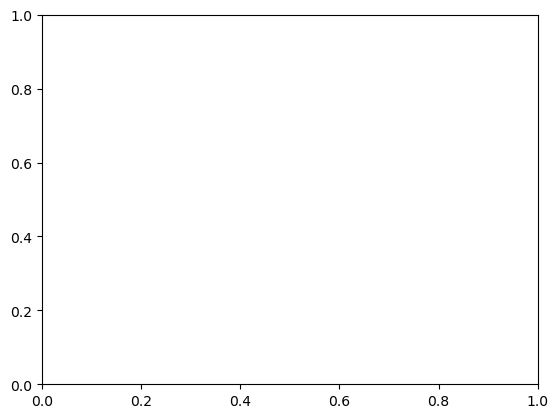

In [5]:
fig,ax = plt.subplots()
atom_list = np.array(atom_table).flatten()
# for atom in atom_list:
#     ax.plot(atom.r_array, atom.h_r_matrix[0,0]+1 )
# ax.plot(atom.r_array, (atom_list[2].h_r_matrix[0,0]+1) - (atom_list[1].h_r_matrix[0,0]+1) )
ax.plot(atom.r_array, np.exp(-atom.βueff_r_matrix[0,0]))
ax.plot(atom.r_array, np.gradient(np.exp(-atom.βueff_r_matrix[0,0]),atom.r_array ))
ax.plot(atom.r_array, np.heaviside(atom.r_array-2,0.5))
ax.plot(atom.r_array, atom.h_r_matrix[0,0]+1)


In [6]:
def HS_Pressure(atom, qsp):
#     R_HS = -0.5*np.sum( atom.del_r*( np.exp(-atom.βueff_r_matrix[0,0]) -1))
    R_HS = 0.5*qsp.ri*atom.r_array[np.argmax(atom.h_r_matrix[0,0])]
    n_AU = qsp.ni
    Vol_AU = 4/3 * π * (R_max*qsp.ri)**3
    N = Vol_AU*n_AU
    
    v_AU = 4/3*π*R_HS**3
    print(Vol_AU/N, v_AU)
    P = N*qsp.Ti/(Vol_AU - N*v_AU)
    return P
HS_Pressure(atom, atomqsp)

NameError: name 'atom' is not defined

In [43]:
def get_U_P(atom, qsp):
    r, dr = qsp.ri*atom.r_array, qsp.ri*atom.del_r
    Vol_AU = 4/3 * π * (R_max*qsp.ri)**3
    g_r, βveff_r, T, n_AU = atom.heff_r_matrix[0,0]+1, atom.βueff_r_matrix[0,0], qsp.Ti, qsp.ni
    veff_r = βveff_r*T
    F = -np.gradient(veff_r, r)
    veff_r = βveff_r*T

    N = Vol_AU*n_AU
    
    U_ideal = 3/2 * N * T
    P_ideal = n_AU * T
    
    U_ex    = 2*π*n_AU*N * np.sum( veff_r * g_r * r**2 * dr, axis=0 )
    P_ex    = 2*π/3 * n_AU**2 * np.sum( F * g_r * r**3 * dr, axis=0)
    return U_ideal + U_ex, P_ideal + P_ex

def get_H(atom, qsp):
    Vol_AU = 4/3 * π * (R_max*qsp.ri)**3
    U, P = get_U_P(atom, qsp)
    return U + P*Vol_AU

# get_U_P(atom, atomqsp), get_H(atom, atomqsp)

In [44]:
%%time
N_bins, R_max = 500, 5

N_table = 3
atom_table = np.zeros((N_table,N_table)).tolist()
H_table = np.zeros((N_table,N_table))
P_table = np.zeros((N_table,N_table))
T_table = np.zeros((N_table,N_table))
ε = 0.1
ni_list = [ni_cc*(1-ε), ni_cc*(1+ε)]
Te_list = [Te*(1-ε), Te*(1+ε)]

ni_list = ni_cc*np.linspace(1-ε, 1+ε, num = N_table)
Te_list = Te*np.linspace(1-ε, 1+ε, num = N_table)

for i, ni_i in enumerate(ni_list):
    for j, Te_j in enumerate(Te_list):
        print(ni_i, Te_j)
        if (i,j) == (0, 0):
            c_s_k_guess = atom.c_s_k_matrix.copy()
        atom, atomqsp = set_hnc(ni_i, Te_j, Z, A, Zstar, 
                                    pseudopotential=True, oz_type='svt',r_c=r_c, 
                                    add_bridge=True, bridge='ocp', N_bins=N_bins, R_max=R_max)
        if (i,j) != (0,0):
            atom.c_s_k_matrix = c_s_k_guess.copy()
        
        atom.HNC_solve(alpha_method='fixed', alpha_Picard = 1, tol=1e-8, alpha_Ng=0, 
                       iters_to_wait=1e4, iters_to_use=2, num_iterations=1e3, verbose=True)
        
        atom.invert_HNC_OZ([])
#         options={'eps':1e-6,'maxfev':10000,'factor':100,'xtol':1e-8} 
#         newton_kwargs= {'method':'hybr', 'options':options} 
#         sol = atom.HNC_newton_solve( **newton_kwargs)
        atom.H = get_H(atom, atomqsp)
        atom.U, atom.P = get_U_P(atom, atomqsp)
        
        H_table[i][j] = atom.H
        P_table[i][j] = atom.P
        T_table[i][j] = Te_j
        atom_table[i][j] = atom

5.3819999999999996e+23 0.06615216
Λei = 0.354
Λee = 0.501
Λei adjusted with R = 0.354
Γii=6.382, Γie=-0.885, Γee=1.135 
r_i=1.441
r_e=1.566
r_c=0.371
θ  =8.81e-02
0: Initial condition Total Error: 1.646e+01
1: Change in c_r: 1.610e-01, HNC Error: 2.154e-02, Total Error: 1.120e+00
2: Change in c_r: 1.135e-01, HNC Error: 1.302e-02, Total Error: 3.462e-01
3: Change in c_r: 8.232e-02, HNC Error: 8.681e-03, Total Error: 1.670e-01
4: Change in c_r: 5.745e-02, HNC Error: 5.726e-03, Total Error: 9.282e-02
5: Change in c_r: 3.856e-02, HNC Error: 3.692e-03, Total Error: 5.442e-02
6: Change in c_r: 2.521e-02, HNC Error: 2.350e-03, Total Error: 3.277e-02
7: Change in c_r: 1.620e-02, HNC Error: 1.485e-03, Total Error: 2.000e-02
8: Change in c_r: 1.030e-02, HNC Error: 9.335e-04, Total Error: 1.231e-02
9: Change in c_r: 6.497e-03, HNC Error: 5.850e-04, Total Error: 7.612e-03
10: Change in c_r: 4.080e-03, HNC Error: 3.658e-04, Total Error: 4.721e-03
11: Change in c_r: 2.555e-03, HNC Error: 2.285e-04, 

8: Change in c_r: 1.528e-03, HNC Error: 1.332e-04, Total Error: 1.753e-03
9: Change in c_r: 9.681e-04, HNC Error: 8.431e-05, Total Error: 1.108e-03
10: Change in c_r: 6.130e-04, HNC Error: 5.335e-05, Total Error: 7.001e-04
11: Change in c_r: 3.879e-04, HNC Error: 3.375e-05, Total Error: 4.426e-04
12: Change in c_r: 2.455e-04, HNC Error: 2.135e-05, Total Error: 2.799e-04
13: Change in c_r: 1.553e-04, HNC Error: 1.350e-05, Total Error: 1.770e-04
14: Change in c_r: 9.824e-05, HNC Error: 8.542e-06, Total Error: 1.119e-04
15: Change in c_r: 6.214e-05, HNC Error: 5.402e-06, Total Error: 7.078e-05
16: Change in c_r: 3.930e-05, HNC Error: 3.417e-06, Total Error: 4.476e-05
17: Change in c_r: 2.486e-05, HNC Error: 2.161e-06, Total Error: 2.831e-05
18: Change in c_r: 1.572e-05, HNC Error: 1.367e-06, Total Error: 1.790e-05
19: Change in c_r: 9.944e-06, HNC Error: 8.645e-07, Total Error: 1.132e-05
20: Change in c_r: 6.289e-06, HNC Error: 5.468e-07, Total Error: 7.162e-06
21: Change in c_r: 3.978e-0

18: Change in c_r: 2.402e-05, HNC Error: 2.046e-06, Total Error: 2.748e-05
19: Change in c_r: 1.540e-05, HNC Error: 1.311e-06, Total Error: 1.761e-05
20: Change in c_r: 9.868e-06, HNC Error: 8.404e-07, Total Error: 1.129e-05
21: Change in c_r: 6.324e-06, HNC Error: 5.386e-07, Total Error: 7.234e-06
22: Change in c_r: 4.053e-06, HNC Error: 3.452e-07, Total Error: 4.636e-06
23: Change in c_r: 2.598e-06, HNC Error: 2.212e-07, Total Error: 2.971e-06
24: Change in c_r: 1.665e-06, HNC Error: 1.418e-07, Total Error: 1.904e-06
25: Change in c_r: 1.067e-06, HNC Error: 9.088e-08, Total Error: 1.220e-06
26: Change in c_r: 6.839e-07, HNC Error: 5.824e-08, Total Error: 7.822e-07
27: Change in c_r: 4.383e-07, HNC Error: 3.733e-08, Total Error: 5.013e-07
28: Change in c_r: 2.809e-07, HNC Error: 2.392e-08, Total Error: 3.213e-07
29: Change in c_r: 1.800e-07, HNC Error: 1.533e-08, Total Error: 2.059e-07
30: Change in c_r: 1.154e-07, HNC Error: 9.826e-09, Total Error: 1.320e-07
31: Change in c_r: 7.394e

In [45]:
from scipy.interpolate import LinearNDInterpolator
T_P_data = list(zip( np.array(T_table).flatten(),np.array(P_table).flatten() ))
H_TP = LinearNDInterpolator(T_P_data, np.array(H_table).flatten())

T, P = np.average(T_table), np.average(P_table) 
C_p_AU = (H_TP(T*(1+1e-6), P) - H_TP(T*(1-1e-6), P))/(2*T*1e-6)
Vol_cc = 4/3 * π * (R_max*r_s_cc)**3
N = Vol_cc * ni_cc
C_p_SI = C_p_AU * k_B
m_p = 1.672621898e-27 # kg
M = N  * A * m_p
c_p_SI_mass = C_p_SI/M # J/kg/K
c_p_SI_vol = C_p_SI/(Vol_cc*1e-6) #J/m^3/K
print("c_p = {0:.3e} [J/m^3/K] = {1:.3e} [erg/cc/K]".format(c_p_SI_vol, c_p_SI_vol*J_to_erg*1e-6 ))
print("c_p^ideal = {0:.3e} [J/m^3/K] = {1:.3e} [erg/cc/K]".format(5/2 * ni_cc* k_B * 1e6, 5/2 * ni_cc* k_B * 1e6*J_to_erg*1e-6 ))

c_p = 1.648e+08 [J/m^3/K] = 1.648e+09 [erg/cc/K]
c_p^ideal = 2.064e+07 [J/m^3/K] = 2.064e+08 [erg/cc/K]


In [46]:
# Compare to Ichimaru
n_AU = ni_cc * (1e2*aB)**3
E_over_nkBT = atom.U/( Te*N )
P_over_nkBT = atom.P/(Te*n_AU)
c_p_over_nkB = C_p_AU/N #c_p_SI_vol/k_B/(ni_cc*1e6)
E_over_nkBT, P_over_nkBT, c_p_over_nkB  

(17.29160072348726, 9.416544575637387, 19.954998774503277)

In [ ]:
# 2x2
#(16.078004224152146, 7.958852940677674, 20.391840227664225)
# 3x3
#(17.29156071613095, 9.41653222069282, 19.954770080816058)
# 4x4
#(17.29156071613095, 9.41653222069282, 20.31577883096223)
# 6x6
#(17.29156071613095, 9.41653222069282, 20.341775951597302)



In [27]:
#cp units are J/K/m^3

10000000.0

In [28]:
c_p_SI_vol *J_to_erg*1e-6 # from J/K/m^3 to erg/K/cc

0.0016794741870226524

In [49]:
(c_p_over_nkB*ni_cc * k_B*1e6)/1e8 # in erg/

1.647540776360547

In [ ]:
# Ideal
# (1.503495387998133, 1.0020009999999997, 2.5033223241241656)


# βu_eff matching

In [177]:
from pandas import read_csv
from scipy.interpolate import interp1d
# luke_file = '/home/zach/plasma/atomic_forces/data/Al_T0p5_tab.lammps.PAIR'
luke_file = '/home/zach/plasma/atomic_forces/data/Al_T1_tab.lammps.PAIR'

luke_data = read_csv(luke_file ,delim_whitespace=True,header=3, names=['r [A]','V [eV]','F [eV/A]'])
# luke_r, luke_βV = 1e-10/aB/r_s*luke_data['r [A]'], 1/(Te/eV)*luke_data['V [eV]']
luke_r, luke_βV = 1e-8/r_s*luke_data['r [A]'], 1/(Te/eV)*luke_data['V [eV]']
luke_βV_function = interp1d(luke_r, luke_βV,fill_value='extrapolate',bounds_error=False)

In [178]:
from scipy.optimize import curve_fit

class βu_fit():
    def __init__(self, func, r_array, y_data, initial_guess):
        self.r = r_array
        self.y = y_data
        self.y_vals = curve_fit(func, r_array, y_data, maxfev=int(1e5), p0=initial_guess)
        self.y_fit  = func(r_array, *self.y_vals[0])
        self.err = np.linalg.norm(self.y_fit-self.y)
        print(func.__name__ + " error: {0:.3e} ".format(self.err))

def yukawa_plus(r, a, b, c, d):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d)))

def yukawa_plus_gaussian(r, a ,b ,c, d ,e, f, g):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + e*np.exp(-(f-r)**2/g)

def yukawa_plus_cos(r, a ,b ,c, d , h, i, j, k, l):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + h*np.cos((r-i)*j*np.exp(-k*r))*np.exp(-l*r)

def yukawa_plus_gaussian_cos(r, a ,b ,c, d ,e, f, g, h, i, j, k, l):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + e*np.cos((r-f)*g*np.exp(-h*r))*np.exp(-i*r) + j*np.exp(-(k-r)**2/l)


In [187]:
atom = atom_highres

In [188]:
atom.invert_HNC_OZ([1])
fit1 = βu_fit(yukawa_plus, atom.r_array, atom.βueff_r_matrix[0,0], initial_guess=[   atomqsp.Γii, atomqsp.get_κ(),2 , 1])
try: 
    fit2 = βu_fit(yukawa_plus_cos, atom.r_array, atom.βueff_r_matrix[0,0], initial_guess=[  *fit1.y_vals[0], 1, 0.01, 1 , 10, 2])
except:
    pass
try:
    fit3 = βu_fit(yukawa_plus_gaussian_cos, atom.r_array, atom.βueff_r_matrix[0,0], initial_guess=[  *fit2.y_vals[0], -1, 1.9, 1])
except:
    pass

yukawa_plus error: 4.442e+01 
yukawa_plus_cos error: 3.221e+01 


/tmp/ipykernel_64608/2646033414.py:19: RuntimeWarning: overflow encountered in exp
  return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + h*np.cos((r-i)*j*np.exp(-k*r))*np.exp(-l*r)
/tmp/ipykernel_64608/2646033414.py:19: RuntimeWarning: overflow encountered in multiply
  return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + h*np.cos((r-i)*j*np.exp(-k*r))*np.exp(-l*r)
/home/zach/.pyenv/versions/3.9.13/envs/atomic_3.9.13/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


yukawa_plus_gaussian_cos error: 1.928e+01 


In [189]:
luke_r

1      0.007092
2      0.016484
3      0.025875
4      0.035267
5      0.044658
         ...   
601    5.636239
602    5.645619
603    5.654999
604    5.664379
605    5.673758
Name: r [A], Length: 605, dtype: float64

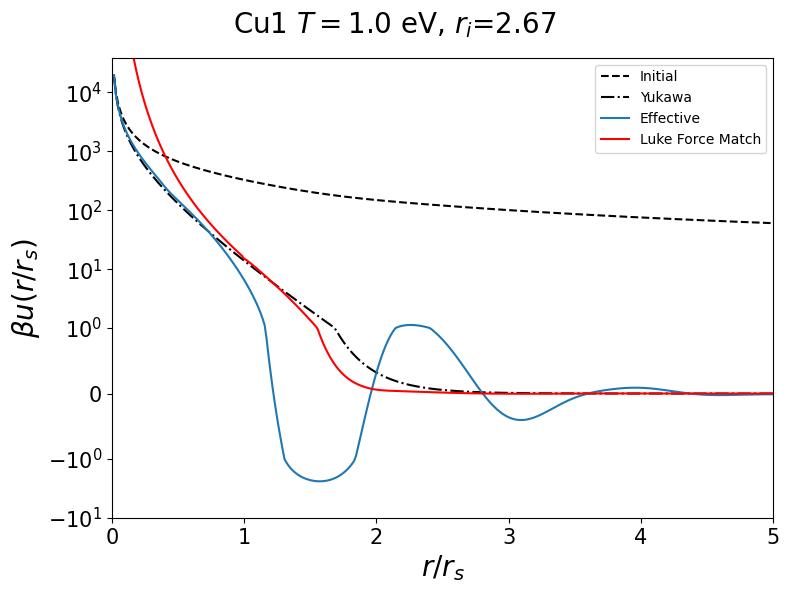

In [190]:
fig, ax = plt.subplots(figsize=(8,6),facecolor='w')
fig.suptitle(r"{0} $T=${1:.1f} eV, $r_i$={2:.2f}".format(case_id, Te/eV, atomqsp.ri), fontsize=20)


yukawa_matrix = (atom.Gamma[:,:,np.newaxis]/atom.r_array * np.exp(-atom.r_array*atomqsp.get_κ())[np.newaxis,np.newaxis,:] ) [:-1,:-1]
coulomb_matrix = (atom.Gamma[:,:,np.newaxis]/atom.r_array) [:-1,:-1]

ax.plot(atom.r_array, atom.βu_r_matrix[0,0], 'k--',label='Initial')
ax.plot(atom.r_array, yukawa_matrix[0,0],'k-.', label="Yukawa")

ax.plot(atom.r_array, atom.βueff_r_matrix[0,0],color=colors[0], label='Effective')    
ax.plot(luke_r, luke_βV,'r-', label='Luke Force Match')

ax.set_ylim(np.min([-10, 2*np.min(atom.βueff_r_matrix[0,0])]), np.max([1e3, 2*np.max(atom.βueff_r_matrix[0,0])]))
ax.tick_params(labelsize=20)
ax.set_xlabel(r"$r/r_s$",fontsize=20)
ax.set_ylabel(r'$\beta u(r/r_s)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)

ax.set_xlim(0, 5)
ax.set_yscale('symlog',linthresh=1)
ax.tick_params(labelsize=15)
ax.legend(fontsize=10)
fig.tight_layout()